interactive(children=(ToggleButtons(button_style='info', description='Anzeige:', options=('PTS', 'REB', 'AST')…

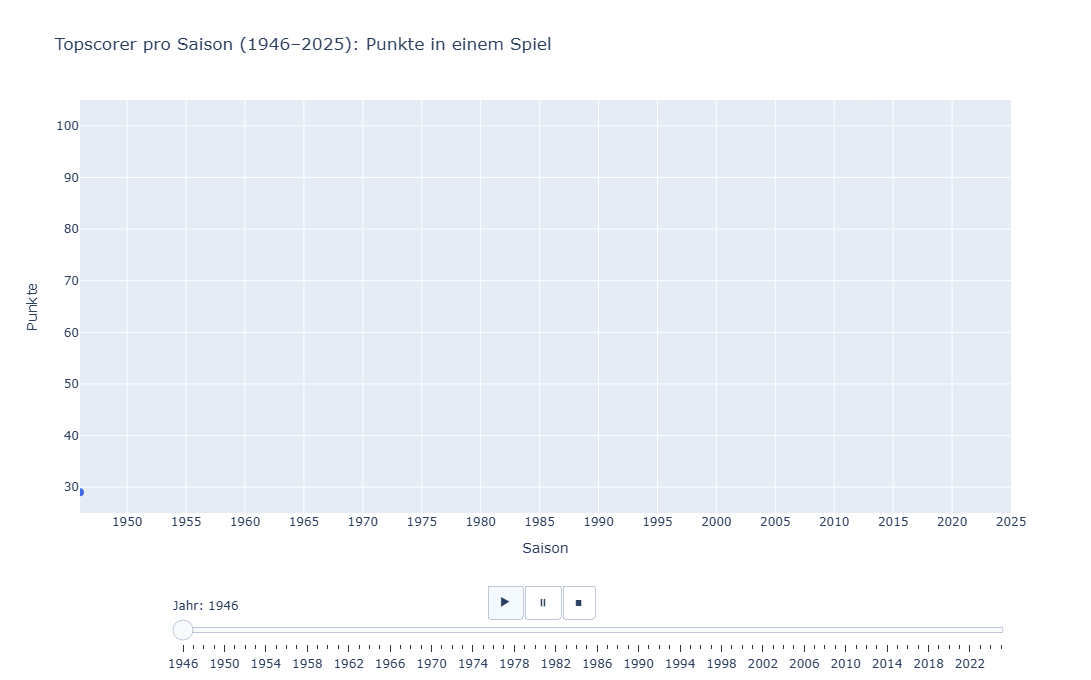

**Top 10 der Spieler, die die meisten Punkte in einem einzigen Spiel erzielt haben (alle Zeiten):**

,Spieler,PTS,Saison
1,Wilt Chamberlain,100.0,1962
2,Kobe Bryant,81.0,2006
3,Wilt Chamberlain,78.0,1961
4,Wilt Chamberlain,73.0,1962
5,David Thompson,73.0,1978
6,Luka Doncic,73.0,2024
7,Wilt Chamberlain,73.0,1962
8,Wilt Chamberlain,72.0,1962
9,Donovan Mitchell,71.0,2023
10,David Robinson,71.0,1994


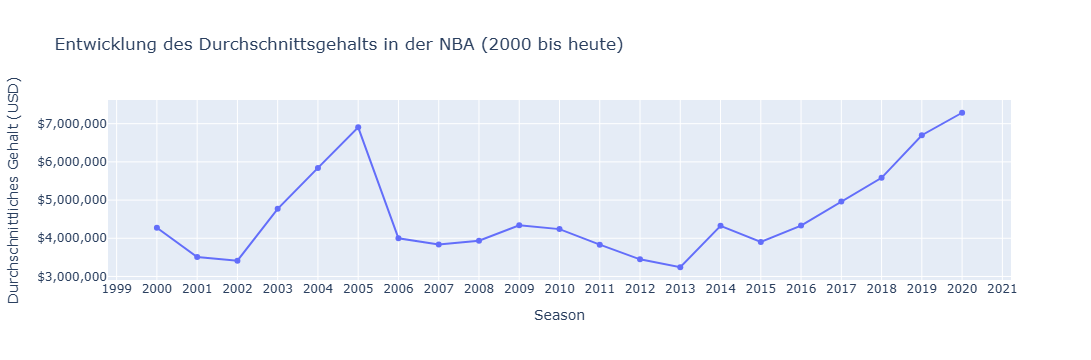

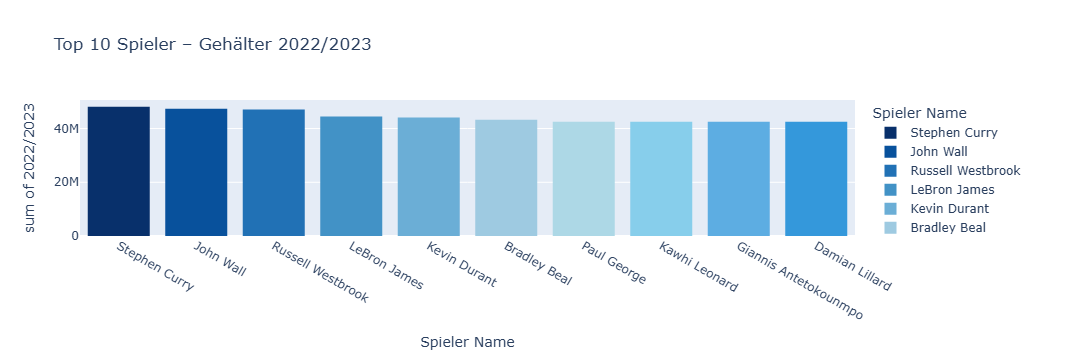

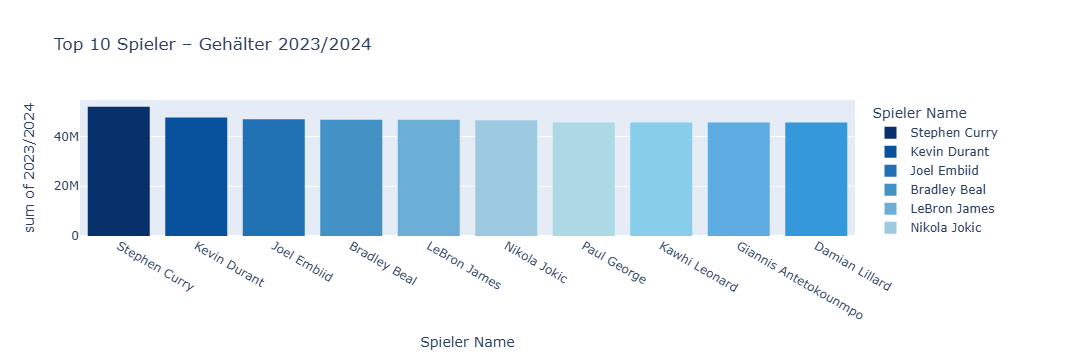

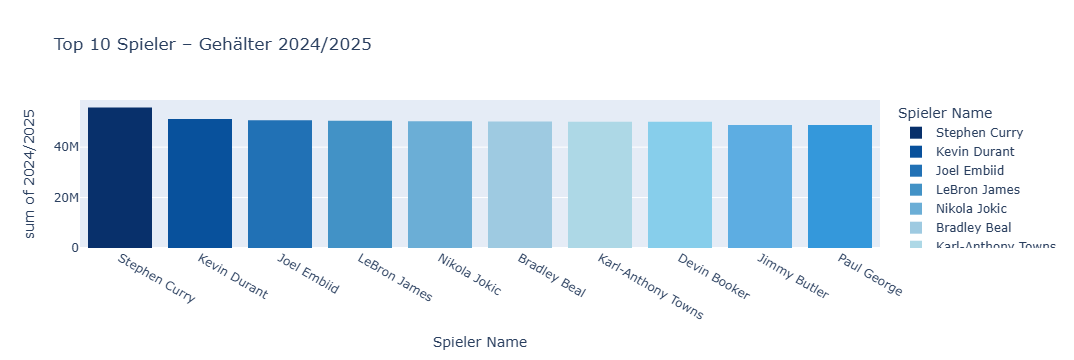

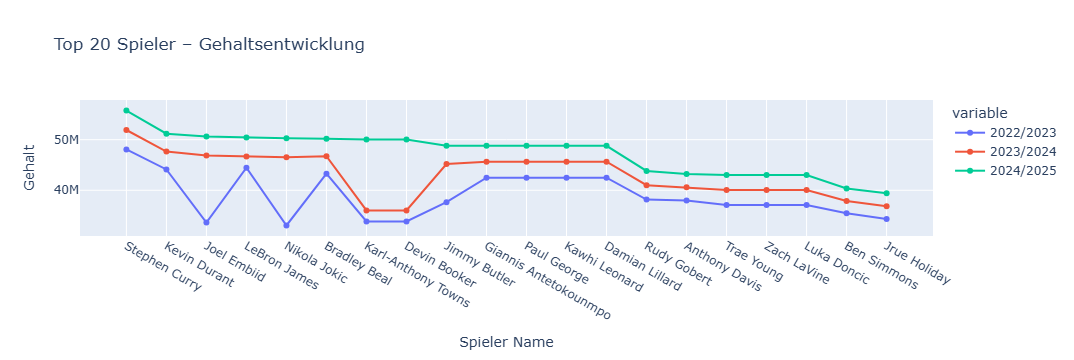

In [2]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

df = pd.read_csv("nba_stats.csv")
df = df[["PLAYER_FIRST_NAME", "PLAYER_LAST_NAME", "PTS", "REB", "AST", "FROM_YEAR", "TO_YEAR"]]
df["Spieler"] = df["PLAYER_FIRST_NAME"] + " " + df["PLAYER_LAST_NAME"]
df = df[["Spieler", "PTS", "REB", "AST", "FROM_YEAR", "TO_YEAR"]]

rows = []
for _, row in df.iterrows():
    for year in range(int(row["FROM_YEAR"]), int(row["TO_YEAR"]) + 1):
        rows.append({
            "Spieler": row["Spieler"],
            "Jahr": year,
            "PTS": row["PTS"],
            "REB": row["REB"],
            "AST": row["AST"]
        })

df_expandido = pd.DataFrame(rows).dropna()
df_expandido["Jahr"] = df_expandido["Jahr"].astype(int)
df_expandido = df_expandido.sort_values(by="Jahr")

def mostrar_grafico(columna):
    if columna == "PTS":
        y_rango = [0, 35]
        y_tick = 5
        color_range = [4, 30]
        color_ticks = list(range(4, 31, 4))
    elif columna == "REB":
        y_rango = [0, 25]
        y_tick = 2
        color_range = [1, 20]
        color_ticks = list(range(1, 21, 2))
    elif columna == "AST":
        y_rango = [0, 14]
        y_tick = 1
        color_range = [1, 12]
        color_ticks = list(range(1, 13, 1))

    df_vis = df_expandido.copy()
    df_vis = df_vis[df_vis[columna].notna()]
    df_vis["Name"] = ""
    df_vis["X_texto"] = df_vis["Jahr"].astype(float)

    for año in df_vis["Jahr"].unique():
        top3 = df_vis[df_vis["Jahr"] == año].nlargest(3, columna)
        for i, (_, fila) in enumerate(top3.iterrows()):
            idx = fila.name
            df_vis.at[idx, "Name"] = f'{fila["Spieler"]} ({fila[columna]:.1f})'
            if i == 0 or i == 2:
                df_vis.at[idx, "X_texto"] = fila["Jahr"] - 1  # top 1 y 3 a la izquierda
            elif i == 1:
                df_vis.at[idx, "X_texto"] = fila["Jahr"] + 1  # top 2 a la derecha

    fig = px.scatter(
        df_vis,
        x="X_texto",
        y=columna,
        size=columna,
        color=columna,
        hover_name="Spieler",
        text="Name",
        animation_frame="Jahr",
        animation_group="Spieler",
        color_continuous_scale=["red", "orange", "yellow", "green"],
        size_max=40,
        range_x=[1946, 2026],
        range_y=y_rango,
        range_color=color_range,
        title=f"Entwicklung der NBA-Spieler nach {columna} (1946–2025)",
        labels={columna: f"Durchschnittliche {columna}", "X_texto": "Jahr"}
    )

    fig.update_traces(textposition="middle left", textfont_size=10)
    fig.update_layout(
        width=1000,
        height=600,
        yaxis=dict(dtick=y_tick),
        plot_bgcolor="white",
        coloraxis_colorbar=dict(
            title=f"Durchschnittliche {columna}",
            tickmode="array",
            tickvals=color_ticks,
            ticktext=color_ticks
        )
    )

    fig.show()

selector = widgets.ToggleButtons(
    options=["PTS", "REB", "AST"],
    description='Anzeige:',
    button_style='info'
)

widgets.interact(mostrar_grafico, columna=selector)

import pandas as pd
import plotly.graph_objects as go

df = pd.read_csv("PlayerStatistics.csv", low_memory=False)
df["fullName"] = df["firstName"].str.strip() + " " + df["lastName"].str.strip()
df["gameDate"] = pd.to_datetime(df["gameDate"], errors="coerce")
df["season"] = df["gameDate"].dt.year
df = df[(df["season"] >= 1946) & (df["season"] <= 2025)]

idx_max = df.groupby("season")["points"].idxmax()
df_max = df.loc[idx_max, ["season", "fullName", "points"]].sort_values("season").reset_index(drop=True)
df_max["label"] = df_max["fullName"] + " (" + df_max["points"].astype(int).astype(str) + " pts)"

selected_years = {1963, 1962, 2006, 1961, 1978, 2024, 2023, 1994}
pos_map = {
    1962: "top center", 1978: "top center", 1990: "top center",
    1994: "top center", 2006: "top center", 2017: "top left",
    2023: "bottom left", 2024: "top left", 1961: "top right",
    1963: "top left"
}
pos_map_default = "top right"

frames = []
past_text_data = []

for year in range(1946, 2026):
    past = df_max[df_max["season"] <= year]

    main_trace = go.Scatter(
        x=past["season"],
        y=past["points"],
        mode="lines+markers",
        marker=dict(size=8),
        line=dict(color="royalblue", width=2),
        showlegend=False,
        customdata=past[["fullName", "points", "season"]].values,
        hovertemplate="Spieler: %{customdata[0]}<br>Punkte: %{customdata[1]}<br>Saison: %{customdata[2]}<extra></extra>"
    )

    if year in selected_years:
        row = df_max[df_max["season"] == year].iloc[0]
        past_text_data.append(dict(
            x=row["season"],
            y=row["points"],
            text=row["label"],
            textposition=pos_map.get(year, pos_map_default)
        ))

    text_trace = go.Scatter(
        x=[d["x"] for d in past_text_data],
        y=[d["y"] for d in past_text_data],
        text=[d["text"] for d in past_text_data],
        textposition=[d["textposition"] for d in past_text_data],
        mode="text",
        showlegend=False,
        hoverinfo="skip"
    )

    frames.append(go.Frame(data=[main_trace, text_trace], name=str(year)))

last = frames[-1]
for i in range(6):
    frames.append(go.Frame(data=last.data, name=f"pause{i}"))

steps = [dict(
    method="animate",
    args=[[str(y)], dict(mode="immediate", frame=dict(duration=0, redraw=True), transition=dict(duration=0))],
    label=str(y)
) for y in range(1946, 2026)]

fig = go.Figure(data=frames[0].data, frames=frames)

fig.update_layout(
    title="Topscorer pro Saison (1946–2025): Punkte in einem Spiel",
    height=680,  # más alto
    margin=dict(t=100, b=100),
    xaxis=dict(range=[1946, 2025], dtick=5, title="Saison"),
    yaxis=dict(range=[25, 105], dtick=10, title="Punkte"),
    updatemenus=[dict(
        type="buttons",
        direction="left",
        x=0.5, y=-0.15,
        xanchor="center", yanchor="top",
        pad=dict(r=10, t=10),
        showactive=True,
        buttons=[
            dict(
                label="▶",
                method="animate",
                args=[None, {"frame": {"duration": 800, "redraw": True},
                             "fromcurrent": True, "transition": {"duration": 400}}]
            ),
            dict(
                label="⏸",
                method="animate",
                args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]
            ),
            dict(
                label="■",
                method="animate",
                args=[[str(1946)], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}]
            )
        ]
    )],
    sliders=[dict(
        active=0,
        pad=dict(t=60),
        x=0.1, y=-0.05,
        currentvalue=dict(prefix="Jahr: "),
        steps=steps,
        len=0.9
    )]
)


fig.show()

top10_alltime = (
    df
    .sort_values("points", ascending=False)
    .loc[:, ["fullName", "points", "season"]]
    .head(10)
    .rename(columns={
        "fullName": "Spieler",
        "points": "PTS",
        "season": "Saison"
    })
)

top10_alltime.index = range(1, 11)

from IPython.display import Markdown, display
display(Markdown("**Top 10 der Spieler, die die meisten Punkte in einem einzigen Spiel erzielt haben (alle Zeiten):**"))
display(top10_alltime)

import pandas as pd

df = pd.read_csv("nba-salaries.csv")

df = df.rename(columns={
    "Rank": "rank",
    "Name": "name",
    "Position": "position",
    "Team": "team",
    "Salary": "salary",
    "Season": "season"
})

df["salary"] = (
    df["salary"]
    .astype(str)              
    .str.replace(r"[^\d]", "", regex=True) 
    .astype(float)            
)

df["season"] = df["season"].astype(int)

df_promedio = (
    df
    .groupby("season", as_index=False)["salary"]
    .mean()
    .rename(columns={"salary": "avg_salary"})
)

import plotly.express as px

fig = px.line(
    df_promedio,
    x="season",
    y="avg_salary",
    labels={
        "season": "Season",
        "avg_salary": "Durchschnittliches Gehalt (USD)"
    },
    title="Entwicklung des Durchschnittsgehalts in der NBA (2000 bis heute)",
    markers=True  # dibuja un punto en cada temporada
)

fig.update_layout(
    hovermode="x unified",     
    xaxis=dict(dtick=1),       
    yaxis_tickprefix="$",      
    yaxis_tickformat=",.0f"    
)

fig.show()


import pandas as pd
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("Nba Player Salaries.csv")

for col in ['2022/2023', '2023/2024', '2024/2025', '2024/2025.1']:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)

df.rename(columns={'Player Name': 'Spieler Name'}, inplace=True)

top_10_2022_2023 = df.nlargest(10, '2022/2023')
top_10_2023_2024 = df.nlargest(10, '2023/2024')
top_10_2024_2025 = df.nlargest(10, '2024/2025')

blue_scale = [
    "#08306b", "#08519c", "#2171b5", "#4292c6", "#6baed6",
    "#9ecae1", "#add8e6", "#87ceeb", "#5dade2", "#3498db"
]

fig1 = px.histogram(top_10_2022_2023, x='Spieler Name', y='2022/2023',
                    color='Spieler Name', title='Top 10 Spieler – Gehälter 2022/2023',
                    color_discrete_sequence=blue_scale)

fig2 = px.histogram(top_10_2023_2024, x='Spieler Name', y='2023/2024',
                    color='Spieler Name', title='Top 10 Spieler – Gehälter 2023/2024',
                    color_discrete_sequence=blue_scale)

fig3 = px.histogram(top_10_2024_2025, x='Spieler Name', y='2024/2025',
                    color='Spieler Name', title='Top 10 Spieler – Gehälter 2024/2025',
                    color_discrete_sequence=blue_scale)

fig1.show()
fig2.show()
fig3.show()

df_sorted = df.sort_values(by='2024/2025', ascending=False)
top_20_players = df_sorted.head(20)

fig = px.line(top_20_players, x='Spieler Name',
              y=['2022/2023', '2023/2024', '2024/2025'],
              title='Top 20 Spieler – Gehaltsentwicklung')

fig.update_layout(xaxis_title='Spieler Name', yaxis_title='Gehalt')
fig.update_traces(mode='lines+markers')

fig.show()
